In [4]:
"""DecisionTree.ipynb

Automatically generated by Colab.

Original file is located at https://colab.research.google.com/drive/1YoQ_zyv1Hg6RIVerjD5Qq8NJkrWO6Qe6?usp=sharing

"""

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [12]:
class Node:
    """
    + Represets a node in the decision tree.
    + Each node has a left and right child, and a split value
    + Each node can be a leaf node or a decision node
    """

    def __init__(self, x=None, y=None, feature=None, threshold=None, feature_list=None):
        """
        Inicialization constructor

        Attributes:
        + x: set of features that the node will use to make a decision. (np.array)
        + y: set of labels that the node will use to make a decision. (np.array)
        + feature: feature choosen (int)
        + threshold: threshold value to split the data (float)
        + feature_list: list of features that can be used to split the data (list)
        + left: left child node (Node)
        + right: right child node (Node)
        """
        self.x = x
        self.y = y
        self.feature = feature
        self.threshold = threshold
        self.feature_list = feature_list
        self.left = None
        self.right = None

    def is_leaf(self):
        """
        Check if the node is a leaf node. If the node has no children, it is a leaf node
        Output: boolean
        """
        return self.left is None and self.right is None

    def is_terminal(self):
        """
        Check if all the labels in y are the same. If so, the node is a terminal node
        Output: boolean
        """
        return len(np.unique(self.y)) == 1

    def sample_size(self):
        """
        Return the number of samples in the node
        Output: int
        """
        return len(self.y)

    def get_value(self):
        """
        Return the most common label in the node
        Output: int
        """
        return np.argmax(np.bincount(self.y)) #ojo

    def _calculate_entropy(self, indices, y):
        """
        Calculate the entropy of the node
        Input: indices (np.array), y (np.array)
        Output: float
        """
        dic = {'0': 0, '1': 0}
        for i in indices:
            dic[str(y[i])] += 1

        entropy = 0
        for value in dic.values():
            if value != 0:
                prob = value / len(indices)
                entropy += -prob * np.log2(prob)
        return entropy

    def _y_entropy(self):
        """
        Calculate the entropy of the labels
        Input: y (np.array)
        Output: float
        """
        dic = {'0': 0, '1': 0}

        for i in self.y:
            dic[str(i)] += 1

        entropy = 0
        for key, value in dic.items():
            prob = value / len(self.y)
            entropy += -prob * np.log2(prob)

        return entropy

    def calculate_info_gain(self, feature, threshold):
        """
        Calculate the information gain of a split
        Input: feature (int), threshold (float)
        Output: float
        """
        left_indices = self.x[self.x[feature] <= threshold].index
        right_indices = self.x[self.x[feature] > threshold].index

        entropy_left = self._calculate_entropy(left_indices, self.y)
        entropy_right = self._calculate_entropy(right_indices, self.y)

        entropy_total = (len(left_indices) / len(self.y) * entropy_left) + (
                len(right_indices) / len(self.y) * entropy_right)
        info_gain = self._y_entropy() - entropy_total

        return info_gain

    def best_split(self):
        """
        Find the best split for the data
        Output: best_feature (int), best_threshold (float)
        """
        best_feature = None
        best_threshold = None
        best_info_gain = float('-inf')

        for feature in self.feature_list:
            threshold = np.mean(self.x[feature])
            info_gain = self.calculate_info_gain(feature, threshold)

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature
                best_threshold = threshold

        return best_feature, best_threshold


class DecisionTree:
    """
    + Decision tree classifier
    + The tree is built recursively by splitting the data at each node
    """

    def __init__(self, x_train, y_train, max_depth=3):
        """
        Inicialization constructor

        Atrributes:
        + x_train: set of features to train the model (np.array)
        + y_train: set of labels to train the model (np.array)
        + max_depth: maximum depth of the tree (int)
        + root: root node of the tree (Node)
        +
        """
        self.x_train = x_train
        self.y_train = y_train
        self.max_depth = max_depth
        self.root = None
        self.minimum_samples = 5
        self.feature_list = x_train.columns.tolist()

    def fit(self):
        """
        Fit the model to the training data. The tree is built recursively by splitting the data at each node
        """
        self.root = self.insert(self.root)

    def insert(self, node):
        """
        Inserts a new node in the tree. If the node is not a leaf node, the data is split at the best feature and threshold
        Input: node (Node)
        Output: node (Node)
        """

        if node is None:
            node = Node(x=self.x_train, y=self.y_train, feature_list=self.x_train.columns.values.tolist())

        if not node.is_terminal() and node.sample_size() > self.minimum_samples and len(node.feature_list) > 0:
            best_feature, threshold = node.best_split()
            node.feature = best_feature
            node.threshold = threshold
            node.feature_list = self._get_new_feature_list(node)
            node = self._set_children(node)

            if node.left is not None and node.left.sample_size() > 0:
                node.left.feature_list = self._get_new_feature_list(node)
                self.insert(node.left)

            if node.right is not None and node.right.sample_size() > 0:
                node.right.feature_list = self._get_new_feature_list(node)
                self.insert(node.right)

        return node

    def _get_new_feature_list(self, node):
        """
        Return the list of features that can be used to split the data
        Input: node (Node)
        Output: list
        """
        #if node.feature is None:
        #    node.feature_list = self.x_train.columns.values.tolist()
        #    return node.feature_list

        current_feature = node.feature
        filtered_features = [feature for feature in node.feature_list if feature != current_feature]
        return filtered_features

    def _set_children(self, node):
        """
        Assign children nodes to the parameter node in base of the threshold. Filters the data and creates the left and right children nodes
        Input: node (Node)
        Output: node (Node)
        """

        x_filtered_left = node.x[node.x[node.feature] <= node.threshold]
        x_filtered_right = node.x[node.x[node.feature] > node.threshold]
        y_filtered_left = node.y[node.x[node.feature] <= node.threshold]
        y_filtered_right = node.y[node.x[node.feature] > node.threshold]

        node.left = Node(x=x_filtered_left, y=y_filtered_left, feature_list=node.feature_list)
        node.right = Node(x=x_filtered_right, y=y_filtered_right, feature_list=node.feature_list)

        return node

    def _predict_recursive(self, x_val, node):
        """
        Predict the label of a sample by traversing the tree recursively
        Input: x_val (np.array), node (Node)
        Output: int
        """
        if node.is_leaf():
            return node.get_value()

        current_feature = node.feature

        if x_val[current_feature].values <= node.threshold:
            return self._predict_recursive(x_val, node.left)
        elif x_val[current_feature].values > node.threshold:
            return self._predict_recursive(x_val, node.right)

    def predict(self, x_test):
        """
        Predict the labels of the test data
        Input: x_test (pd.DataFrame)
        Output: y_pred (np.array)
        """
        y_pred = []

        for i, row in x_test.iterrows():
            row_df = pd.DataFrame(row).T
            y_pred.append(self._predict_recursive(row_df, self.root))

        return np.array(y_pred)

    def print(self, node, depth=0):
        """
        Print the tree
        Input: node (Node), depth (int)
        """
        indent = "    " * depth
        if node is not None:
            if node.is_leaf():
                print(
                    f"{indent}Leaf: Samples={node.sample_size()}, Value={node.get_value()}")
            else:
                print(f"{indent}Node: Feature={node.feature} <= {node.threshold:.2f}, Info_Gain={node.calculate_info_gain(node.feature, node.threshold):.2f}, Samples={node.sample_size()}, Value={node.get_value()}")
                print(f"{indent}Left:")
                self.print(node.left, depth + 1)
                print(f"{indent}Right:")
                self.print(node.right, depth + 1)

    def hello(self):
        print("Hello from DecisionTreeModel")

## Load the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/ml_p2_data/audio_features.csv"

Mounted at /content/drive


In [7]:
df = pd.read_csv(path)

# Split the data into a training and test set
X = df.drop(columns=['covid'])
Y = df['covid']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Xtrain:', X_train.shape)
print('Xtest:', X_test.shape)

#X_train = pd.DataFrame(X_train)
#X_test = pd.DataFrame(X_test)
#y_train = pd.Series(y_train)
#y_test = pd.Series(y_test)

Xtrain: (949, 40)
Xtest: (408, 40)


## Balancing the data

In [8]:
from sklearn.utils import shuffle

positive_samples = df[df['covid'] == 1]
negative_samples = df[df['covid'] == 0]

print(positive_samples.shape)
print(negative_samples.shape)

positive_samples_duplicated = positive_samples.sample(n=1057, replace=True, random_state=42)

df_balanced = pd.concat([negative_samples, positive_samples, positive_samples_duplicated]).reset_index(drop=True)
df_balanced = shuffle(df_balanced, random_state=42)

print(df_balanced['covid'].value_counts())

X = pd.DataFrame(df_balanced.drop(columns=['covid']))
Y = pd.Series(df_balanced['covid'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Xtrain:', X_train.shape)
print('Xtest:', X_test.shape)

(150, 41)
(1207, 41)
covid
0    1207
1    1207
Name: count, dtype: int64
Xtrain: (1931, 40)
Xtest: (483, 40)


### DecisionTree Implemented

In [9]:
tree = DecisionTree(X_train, y_train)
tree.fit()

Accuracy: 0.9420289855072463
Precision: 0.9469545839325236
Recall: 0.9420289855072463
F1 Score: 0.9416957667649737
              precision    recall  f1-score   support

           0       1.00      0.88      0.94       229
           1       0.90      1.00      0.95       254

    accuracy                           0.94       483
   macro avg       0.95      0.94      0.94       483
weighted avg       0.95      0.94      0.94       483



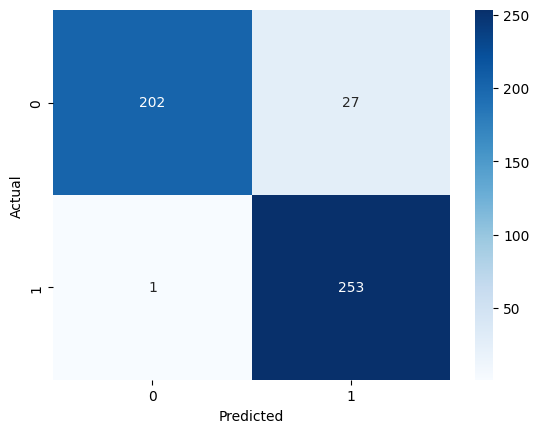

In [20]:
y_pred = tree.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred,  average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### DecisionTree Library

Accuracy: 0.9598418972332016
Recall: 0.9565217391304348
F1 Score: 0.9563400570135785


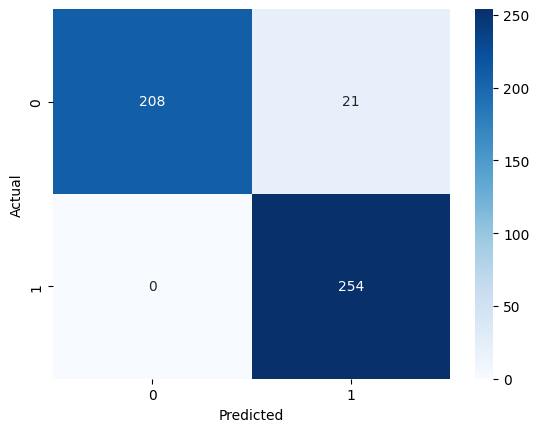

In [11]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)

y_pred = DecisionTree.predict(X_test)

print('Accuracy:', precision_score(y_test, y_pred,  average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## K-fold cross-validation

In [13]:
def k_divisions(X, k):
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    folds = np.array_split(index, k)
    return folds

def k_trees(X_train, y_train):
    k_tree = DecisionTree(X_train, y_train)
    k_tree.fit()
    return k_tree

def k_predictions(k_tree, X_test):
    k_y_pred = k_tree.predict(X_test)
    return k_y_pred

def kfold_cross_validation(X, y, k):
    folds = k_divisions(X, k)
    metrics = {'accuracy': [], 'precision':[], 'recall':[], 'f1-score': []}

    for i in range(k):
        test_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(k) if j != i])

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        k_tree = k_trees(X_train, y_train)
        k_y_pred = k_predictions(k_tree, X_test)

        metrics['accuracy'].append(accuracy_score(y_test, k_y_pred))
        metrics['precision'].append(precision_score(y_test, k_y_pred,  average='weighted'))
        metrics['recall'].append(recall_score(y_test, k_y_pred,  average='weighted'))
        metrics['f1-score'].append(f1_score(y_test, k_y_pred, average='weighted'))
        f1 = f1_score(y_test, k_y_pred, average='weighted')

    accuracy_prom = np.mean(metrics['accuracy'])
    precision_prom = np.mean(metrics['precision'])
    recall_prom = np.mean(metrics['recall'])
    f1score_prom = np.mean(metrics['f1-score'])

    return [accuracy_prom, precision_prom, recall_prom, f1score_prom]

In [17]:
experiments = []
k_folds = [2, 3, 4, 5, 6, 7, 8, 9]
for k in k_folds:
    experiments.append(kfold_cross_validation(X,Y,k))

print(experiments)

[[0.8902236951118475, 0.8983071168756227, 0.8902236951118475, 0.8896769749839278], [0.9175731075471504, 0.9218250313627224, 0.9175731075471504, 0.9173723174908388], [0.9117745983108739, 0.9184044109030494, 0.9117745983108739, 0.9113695919655111], [0.9349570028263876, 0.939405299472803, 0.9349570028263876, 0.934804562834541], [0.9287516100226739, 0.9360387638398945, 0.9287516100226739, 0.9284973083700918], [0.9312280321633202, 0.9379733655662263, 0.9312280321633202, 0.9309490312459145], [0.9304085718686057, 0.9382446673106537, 0.9304085718686057, 0.9300538944187244], [0.9333058992521903, 0.9397373344047543, 0.9333058992521903, 0.9330996235994797]]


In [15]:
result = pd.DataFrame(experiments, columns=['accuracy', 'precision', 'recall', 'f1-score'])
result.index = k_folds
result

,accuracy,precision,recall,f1-score
2,0.871582,0.875601,0.871582,0.871242
3,0.898095,0.909230,0.898095,0.897417
4,0.923777,0.931203,0.923777,0.923453
5,0.936623,0.941974,0.936623,0.936467
6,0.932478,0.938489,0.932478,0.932260
7,0.932065,0.938361,0.932065,0.931863
8,0.934141,0.940356,0.934141,0.933868
9,0.940762,0.947399,0.940762,0.940636


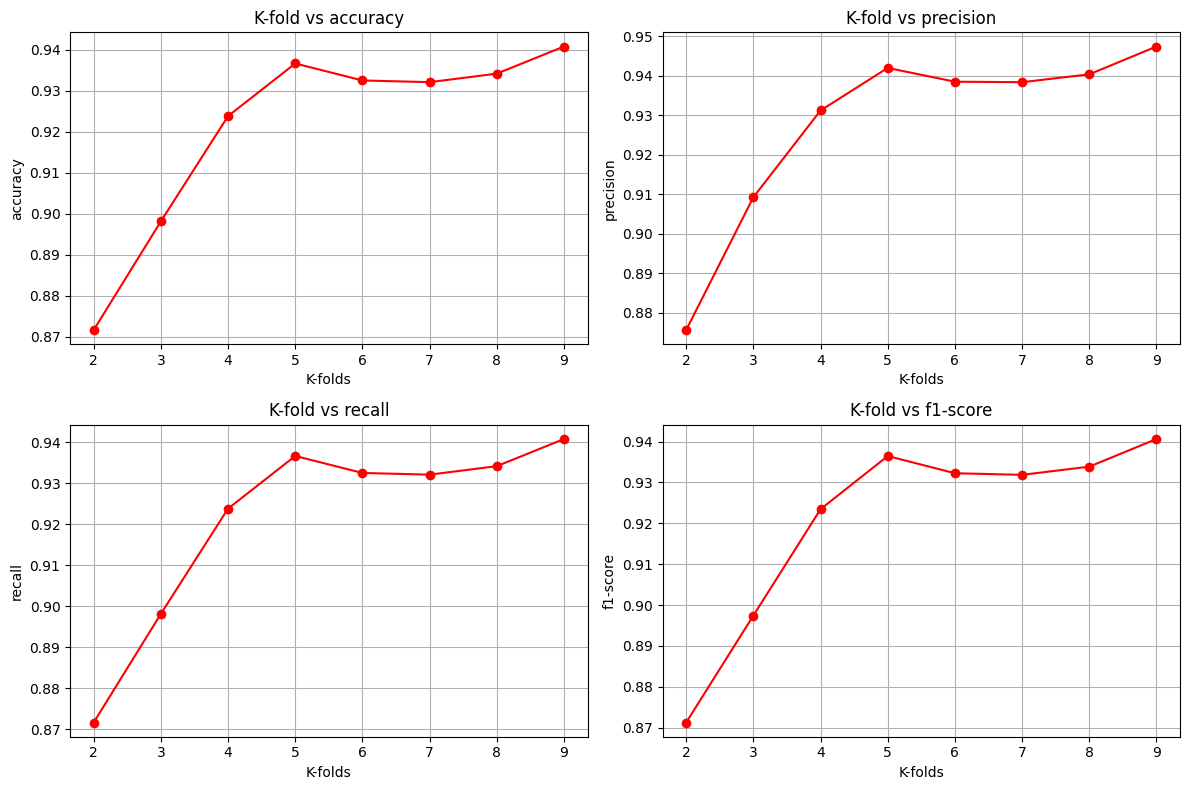

In [16]:
color_scheme = 'red'
data_columns = result.columns[:]
columns_in_row = 2
total_metrics = len(data_columns)
rows_in_layout = (total_metrics + columns_in_row - 1) // columns_in_row

figure, ax_list = plt.subplots(rows_in_layout, columns_in_row, figsize=(12, 8))
ax_list = ax_list.ravel()

for index, metric_name in enumerate(data_columns):
    ax_list[index].plot(result.index, result[metric_name], marker='o', linestyle='-', color=color_scheme)
    ax_list[index].set_title(f'K-fold vs {metric_name}')
    ax_list[index].set_xlabel('K-folds')
    ax_list[index].set_ylabel(metric_name)
    ax_list[index].ticklabel_format(style='plain', axis='y')
    ax_list[index].yaxis.set_major_formatter(mticker.FuncFormatter(lambda value, _: f'{value:.2f}'))
    ax_list[index].grid(True)

for empty_idx in range(index + 1, len(ax_list)):
    figure.delaxes(ax_list[empty_idx])

plt.tight_layout()
plt.show()
